In [38]:
# Modules
import numpy as np
import xarray as xr
import pandas as pd

from data import data_loader
from data import gesla_preprocessing
from data import era5_preprocessing
from data import preprocessing

# Not Modularized Examples

In [39]:
import importlib
importlib.reload(preprocessing)

<module 'data.preprocessing' from 'd:\\OneDrive\\Alle_Ordner\\Coding\\Python\\master_thesis\\data\\preprocessing.py'>

In [40]:
# ---
# Preprocessing
# ---

model_run = "rf002"

# Get timeseries of predictor and predictand
percentile = 0.95
predictors = ["sp", "tp", "u10", "v10",]
predictor = "sp"
season = "winter"

X, Y, t = preprocessing.preprocessing1(season, predictor, percentile)

print(X.shape, Y.shape, t.shape)
# Handle NaN values: 
# Insert numerical value that is not in data.
# ML will hopefully recognize it.
X[np.where(np.isnan(X))] = -999

# Save number of lat/lon for interpreting model output later
ndim = X.shape[0]
nlat = X.shape[1]
nlon = X.shape[2]

# Prepare shape for model
X = X.reshape(ndim, -1) # (ndim, nclasses)
y = Y[:, 0] # Select only one station

Load ERA5-Predictor: sp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Load Predictand from GESLA
Applied one-hot-encoding
Get overlapping timeseries of ERA5 and GESLA
(903, 121, 141) (903, 2) (903,)


test_score: 0.8893805309734514
train_score: 0.96602658788774
importances: [2.81470038e-04 2.38500288e-04 2.17339362e-05 ... 8.34658324e-05
 1.02272006e-04 3.87086328e-05]
Metric values 

tnr: 0.9238578680203046
tpr: 0.6551724137931034
gmean: 0.7780014070633892
wacc: 0.789515140906704
precision: 0.5588235294117647
recall: 0.6551724137931034
fmeasure: 0.6031746031746031


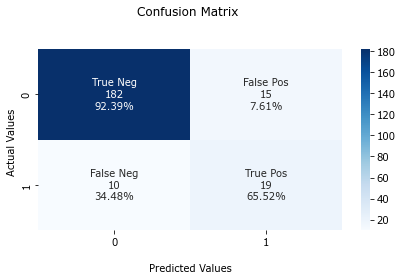

In [35]:
#---
# Train Model
#---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pickle

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

# Load Hyperparameters
folder = f"models/random_forest/{model_run}/"
fname = f"{model_run}_{predictor}{str(percentile)[-2:]}.pkl"

with open(f"{folder}{fname}", 'rb') as f:
    params = pickle.load(f)

params
# Fit the model
model = RandomForestClassifier(criterion='gini',
n_estimators=params["n_estimators"], #- nTrees 
max_depth=params["max_depth"], 
min_samples_leaf=params["min_samples_leaf"],
min_samples_split=params["min_samples_split"],
random_state=0, # To compare results when changing hyperparameters
class_weight="balanced",
oob_score=True,
)

model.fit(X_train, y_train)
#---
# Evaluate model / Diagnostic
#--- 
# Score & Importance
test_score = model.score(X_test, y_test)
train_score = model.score(X_train, y_train)
importances = model.feature_importances_

print(f"test_score: {test_score}")
print(f"train_score: {train_score}")
print(f"importances: {importances}")

%matplotlib inline
#---
#  Diagnostics
#---

# Confusion matrix
#---
# Format: 
# Reality / Model: Negative, Positive
# Negative    Right Negative, False Positive 
# Positive    False Negative, Right Positive

from sklearn.metrics import confusion_matrix
from models import evaluation

y_test_pred = model.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_test_pred)

cfm_fig = evaluation.plot_cf(model, X_test, y_test)
metrics = evaluation.cfm_metrics(model, X_test, y_test)

# # Save results
# folder = "results/"
# fname = f"{folder}cf_matrix.png"
# cfm_fig.savefig(fname)

# fname = f"importances_{predictor}{str(percentile)[-2:]}"
# np.save(f"{folder}{fname}", importances)
# print(f"saved importances to : {folder}{fname}")

AUC: 0.881848415893576


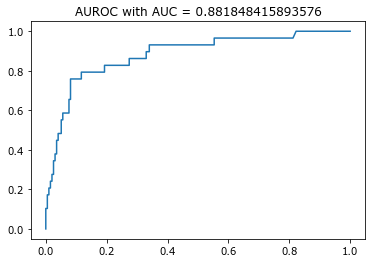

In [36]:
# AUROC
# Receiver Operating Characteristics & Area Under the Curve
#---
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_test_proba = model.predict_proba(X_test)[:, 1] # Prob. for predicting 0 or 1, we only need second col

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc = roc_auc_score(y_test, y_test_proba)

print(f'AUC: {auc}')

fig, ax = plt.subplots()

plt.plot(fpr, tpr)
plt.title(f"AUROC with AUC = {auc}")
plt.show()

In [ ]:
#--- 
# Optimization of HP with VC
#---
from models.random_forest import rf002

percentiles = [0.95, 0.99]
for percentile in percentiles:
    rf002.optimization(percentile)

In [ ]:
#---
# Reading hparams from VC and save it
#---
from models.random_forest import rf002

predictor = "v10"
percentile = 0.95

min_samples_leaf = 4
max_depth = 10
min_samples_split = 4
n_estimators = 100

hparams = (min_samples_leaf, max_depth, min_samples_split, n_estimators)
rf002.save_hp(hparams, predictor, model_run="rf002", percentile=percentile,)

Load ERA5-Predictor: sp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Load ERA5-Predictor: sp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Load ERA5-Predictor: tp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Load ERA5-Predictor: tp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Load ERA5-Predictor: u10 in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Load ERA5-Predictor: u10 in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Load ERA5-Predictor: v10 in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Load ERA5-Predictor: v10 in region: lon-0530_lat7040 for years: 1999-2008 in season: winter


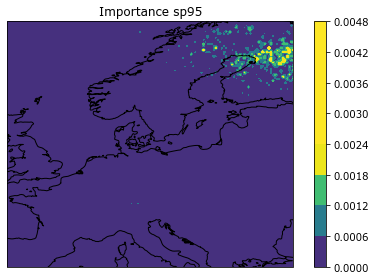

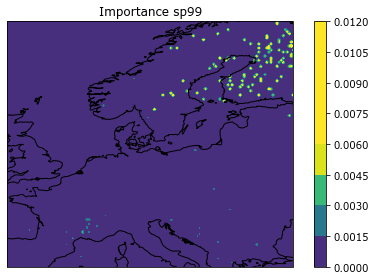

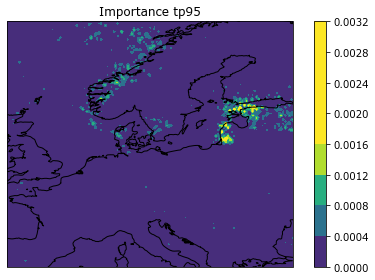

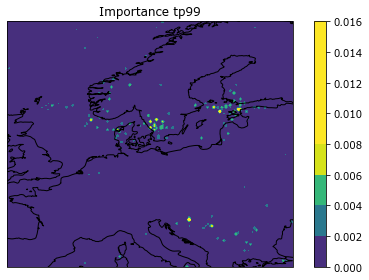

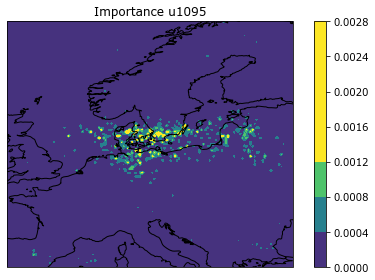

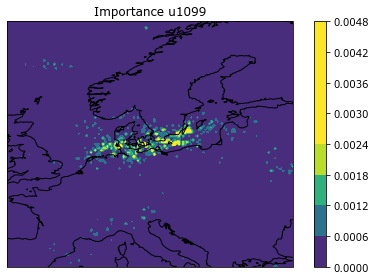

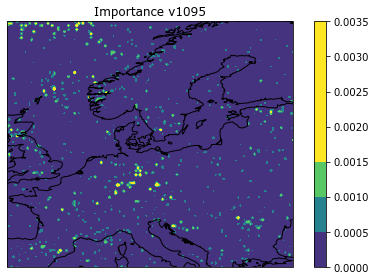

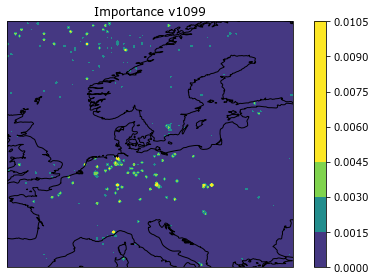

In [37]:
#---
# Visualization
#---

# Metric: Importance
#---
from data import preprocessing

# Initialize
model_run = "rf002"
predictors = ["sp", "tp", "u10", "v10",]
percentiles = [0.95, 0.99]
range_of_years = "1999-2008"
subregion = "lon-0530_lat7040"
season = "winter"
preprocess = "preprocess1"

for predictor in predictors:
    for percentile in percentiles:
        # Load importance
        folder = f"results/random_forest/{model_run}/{predictor}/"
        fname = f"importances_{predictor}{str(percentile)[-2:]}"
        importance = np.load(f"{folder}{fname}.npy")

        # Load lat lons
        lats, lons = preprocessing.get_lonlats(
            range_of_years,
            subregion,
            season,
            predictor,
            preprocess,
        )

        # Plot importance-map
        from models import evaluation
        tflag = f"{predictor}{str(percentile)[-2:]}"
        fig = evaluation.importance_map(importance, lons, lats, tflag=tflag)

        # # Save importance-map
        # folder = f"results/random_forest/rf002/{predictor}/"
        # fname = f"importance_map_{predictor}{str(percentile)[-2:]}"
        # fig.savefig(f"{folder}{fname}.jpg")